In [1]:
from langchain_core.embeddings import Embeddings
from langchain.vectorstores import FAISS
from sentence_transformers import SentenceTransformer
from typing import List
import pickle
import os

In [2]:
%run "wall_of_imports.ipynb"
%run "agent_state.ipynb"

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
llm = ChatOpenAI(model="gpt-4-turbo", temperature=0.7)

C:\Users\dabra\AppData\Local\Temp\ipykernel_19876\575416940.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4-turbo", temperature=0.7)


In [15]:
class FineTunedTravelEmbeddings(Embeddings):
    """LangChain-compatible wrapper for the fine-tuned travel embeddings"""
    
    def __init__(self, model_path="travel_assistant_embeddings", device=None):
        """
        Initialize with the path to the fine-tuned model
        
        Args:
            model_path: Path to the directory containing model.safetensors
            device: Device to run the model on ('cpu' or 'cuda')
        """
        self.model = SentenceTransformer(model_path, device=device)
        print(f"Loaded fine-tuned model from {model_path} with dimension {self.model.get_sentence_embedding_dimension()}")
    
    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Generate embeddings for a list of documents"""
        embeddings = self.model.encode(
            texts,
            batch_size=32,
            show_progress_bar=len(texts) > 50,
            convert_to_numpy=True
        )
        return embeddings.tolist()
    
    def embed_query(self, text: str) -> List[float]:
        """Generate embedding for a query"""
        embedding = self.model.encode(text, convert_to_numpy=True)
        return embedding.tolist()

In [16]:
def extract_documents_from_vector_store(vector_store_path='travel_db_faiss', docstore_path='travel_db_docstore.pkl'):
    """
    Load documents directly from the FAISS vector store
    
    Args:
        vector_store_path: Path to the FAISS vector store
        embeddings: Embeddings model to use (can be None for loading)
        
    Returns:
        List of document objects
    """
     
    # Load the vector store
    vector_store = FAISS.load_local(vector_store_path, OpenAIEmbeddings(), allow_dangerous_deserialization=True)

    # Load the docstore
    with open(docstore_path, 'rb') as f:
        vector_store.docstore = pickle.load(f)
    
    # Verify it loaded correctly
    print(f"Loaded knowledge base with {len(vector_store.index_to_docstore_id)} documents")

    # Get all documents
    documents = []

    # Access the underlying docstore
    for _, doc_id in vector_store.index_to_docstore_id.items():
        if doc_id in vector_store.docstore._dict:
            doc = vector_store.docstore._dict[doc_id]
            documents.append(doc)
    
    print(f"Extracted {len(documents)} documents from vector store")
    return documents

In [17]:
def update_faiss_with_new_embeddings(
    documents,
    fine_tuned_model_path="travel_assistant_embeddings",
    output_path="travel_db_fine_tuned",
    docstore_output_path="travel_db_fine_tuned_docstore.pkl"
):
    """
    Update the FAISS vector store with new embeddings from the fine-tuned model
    
    Args:
        documents: List of documents extracted from original vector store
        fine_tuned_model_path: Path to the fine-tuned model
        output_path: Path to save the new FAISS vector store
        docstore_output_path: Path to save the new docstore
    
    Returns:
        New FAISS vector store
    """
    # Initialize the new embeddings model
    embeddings = FineTunedTravelEmbeddings(model_path=fine_tuned_model_path)
    
    # Create a new FAISS vector store with the documents and new embeddings
    print(f"Creating new FAISS vector store with {len(documents)} documents...")
    new_vector_store = FAISS.from_documents(documents, embeddings)
    
    # Save the new vector store
    new_vector_store.save_local(output_path)
    
    # Save the docstore separately for easier access
    with open(docstore_output_path, 'wb') as f:
        pickle.dump(new_vector_store.docstore, f)
    
    print(f"New FAISS vector store saved to {output_path}")
    print(f"New docstore saved to {docstore_output_path}")
    
    return new_vector_store

In [18]:
# Path to your fine-tuned model
fine_tuned_model_path = "travel_assistant_embeddings"

In [7]:
# 1. Extract documents from existing vector store
documents = extract_documents_from_vector_store()

Loaded knowledge base with 5029 documents
Extracted 5029 documents from vector store


In [8]:
# 2. Create new vector store with fine-tuned embeddings
new_vector_store = update_faiss_with_new_embeddings(
    documents,
    fine_tuned_model_path=fine_tuned_model_path,
    output_path="travel_db_fine_tuned",
    docstore_output_path="travel_db_fine_tuned_docstore.pkl"
)

Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Creating new FAISS vector store with 5029 documents...


Batches:   0%|          | 0/158 [00:00<?, ?it/s]

New FAISS vector store saved to travel_db_fine_tuned
New docstore saved to travel_db_fine_tuned_docstore.pkl


In [19]:
### 3. UPDATED RAG Chain Setup - For Information Retrieval
def setup_rag_chain_fine_tuned():
    """Set up the RAG chain with fine-tuned embeddings for information retrieval."""
    # Use the fine-tuned embeddings
    embeddings = FineTunedTravelEmbeddings(model_path="travel_assistant_embeddings")
    
    # Load the vector store with fine-tuned embeddings
    travel_db_fine_tuned = FAISS.load_local(
        "travel_db_fine_tuned", 
        embeddings,
        allow_dangerous_deserialization=True
    )
    
    # Load the docstore
    with open('travel_db_fine_tuned_docstore.pkl', 'rb') as f:
        travel_db_fine_tuned.docstore = pickle.load(f)
    
    # Create a retriever from the travel knowledge base
    retriever = travel_db_fine_tuned.as_retriever(
        search_type="similarity",
        search_kwargs={"k": 7}
    )
    
    rag_prompt = ChatPromptTemplate.from_template("""You are a knowledgeable travel assistant with expertise in destinations worldwide.
        Use the following travel information to provide detailed, accurate responses to the user's query.
        If the retrieved information doesn't fully answer the question, use your knowledge to provide
        the best possible response, but prioritize the retrieved information.
        
        Retrieved information: {context}        
        Question: {input}
    """)

    # Create the document processing chain using the prompt and language model
    document_chain = create_stuff_documents_chain(llm, rag_prompt)
    
    return create_retrieval_chain(retriever, document_chain)

In [5]:
def router_agent_fine_tuned(state: AgentState) -> dict:
    """Router agent that determines which specialized agent should handle the query."""

    # Step 1: Creates a chat prompt template with system and human messages
    router_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a travel assistant router. Your job is to determine which specialized agent
        should handle the user's travel-related query. Choose the most appropriate agent from:
        
        - itinerary_agent: For requests to create travel itineraries, vacation plans, or multi-day travel schedules
        - flight_agent: For questions about flights, airfares, airlines, or flight bookings
        - accommodation_agent: For questions about hotels, resorts, accommodations, or places to stay
        - information_agent: For general travel information, destination facts, or travel advice
        
        Respond ONLY with the name of the appropriate agent. Do not include any explanations or additional text.
        """),
        ("human", "{query}")
    ])
    
    # Step 2: Uses a chain to pass the user query to the LLM, get the recommended agent name and parse the output as a string
    chain = router_prompt | llm | StrOutputParser()

    agent_executor = chain.invoke({"query": state.query}).strip()
    
    valid_agents = ["itinerary_agent_fine_tuned", "flight_agent_fine_tuned", "accommodation_agent_fine_tuned", "information_agent_fine_tuned"]

    # Step 3: Validates the response: Checks if returned agent name is in valid_agents list, else defaults to "information_agent" if invalid
    if agent_executor not in valid_agents:
        # Default to information agent if invalid response
        agent_executor = "information_agent_fine_tuned"
            
    # Step 4: Returns state as a dictionary
    return {"agent_executor": agent_executor, 
            "query": state.query,
            "chat_history": state.chat_history,
            "agent_response": state.agent_response,
            "final_response": state.final_response,
            "context": state.context,
            "error": state.error}

In [6]:
def accommodation_agent_fine_tuned(state: AgentState) -> dict:
    """Provides hotel and accommodation recommendations."""
    try:
        # Extract accommodation preferences
        extraction_prompt = ChatPromptTemplate.from_messages([
            ("system", """Extract accommodation preferences from the user's query.
            Return a JSON object with these fields (leave empty if not mentioned):
            {{
                "location": "city or specific area",
                "check_in_date": "in YYYY-MM-DD format",
                "check_out_date": "in YYYY-MM-DD format",
                "guests": "number of guests",
                "rooms": "number of rooms",
                "budget_range": "price range per night"
            }}
            """),  # Note the double curly braces
            ("human", "{query}")
        ])
        
        extraction_chain = extraction_prompt | llm | StrOutputParser()
        try:
            accommodation_params = json.loads(extraction_chain.invoke({"query": state.query}))
            state.context.update({"accommodation_params": accommodation_params})
        except json.JSONDecodeError:
            state.context.update({"accommodation_params": {}})
        
        # Get accommodation information using RAG
        rag_chain = setup_rag_chain_fine_tuned()
        retrieval_result = rag_chain.invoke({"query": f"hotels in {state.context.get('accommodation_params', {}).get('location', '')}"})
        
        # Generate response based on accommodation parameters and retrieved information
        accommodation_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a hotel and accommodation expert. Provide detailed recommendations
            based on the user's preferences and the retrieved accommodation data. Include:
            
            - Suitable hotel/accommodation options
            - Price ranges and value considerations
            - Location benefits and proximity to attractions
            - Amenities and facilities
            - Guest ratings and reviews summary
            - Booking tips and optimal timing
            
            If specific accommodation data isn't available, provide general advice about
            accommodations in the requested location, typical options at different price points,
            and best areas to stay.
            
            Retrieved accommodation information:
            {context}
            
            Extracted accommodation parameters:
            {accommodation_params}
            """),
            ("human", "{query}")
        ])
        
        accommodation_chain = accommodation_prompt | llm | StrOutputParser()
        response = accommodation_chain.invoke({
            "query": state.query,
            "context": retrieval_result.get("context", ""),
            "accommodation_params": json.dumps(state.context.get("accommodation_params", {}), indent=2)
        })
        
        return {"agent_response": response}
        
    except Exception as e:
        return {"error": str(e)}

In [7]:
def information_agent_fine_tuned(state: AgentState) -> dict:
    """Answers general travel questions using RAG."""
    try:
        # This agent directly uses the RAG chain to provide travel information
        rag_chain = setup_rag_chain_fine_tuned()
        result = rag_chain.invoke({"input": state.query})  # Changed from query to input
        
        # Enhance RAG response with additional context if needed
        enhancement_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a knowledgeable travel information specialist. Review and enhance
            the retrieved information to provide a comprehensive, accurate response to the user's query.
            
            If the retrieved information is incomplete, add relevant details from your knowledge while
            clearly distinguishing between retrieved facts and general knowledge.
            
            Focus on providing practical, useful information that directly addresses the user's needs.
            Include cultural insights, traveler tips, and seasonal considerations when relevant.
            
            Retrieved information:
            {rag_response}
            """),
            ("human", "{input}")  # Changed from query to input
        ])
        
        enhancement_chain = enhancement_prompt | llm | StrOutputParser()
        enhanced_response = enhancement_chain.invoke({
            "input": state.query,
            "rag_response": result.get("answer", "")
        })
        
        return {"agent_response": enhanced_response}
        
    except Exception as e:
        return {"error": str(e)}

In [8]:
def flight_agent_fine_tuned(state: AgentState) -> dict:
    """Handles flight-related questions and searches."""
    try:
        # Extract flight search parameters
        extraction_prompt = ChatPromptTemplate.from_template("""Extract flight search parameters from the user's query.
            Return a JSON object with these fields (leave empty if not mentioned):
        {{
            "origin": "origin airport or city code",
            "destination": "destination airport or city code",
            "departure_date": "departure date in YYYY-MM-DD format",
            "return_date": "return date in YYYY-MM-DD format (if round-trip)",
            "num_passengers": "number of passengers",
            "cabin_class": "economy/business/first",
            "price_range": "budget constraints",
            "airline_preferences": ["preferred airlines"]
        }}
        
        Query: {input}
        """)       
        
        extraction_chain = extraction_prompt | llm | StrOutputParser()

        try:
            flight_params = json.loads(extraction_chain.invoke({"input": state.query}))  # Changed from input.query to state.query
            state.context.update({"flight_params": flight_params})
        except json.JSONDecodeError:
            state.context.update({"flight_params": {}})
        
        # Get flight information using RAG
        rag_chain = setup_rag_chain_fine_tuned()
        retrieval_result = rag_chain.invoke({"input": state.query})

        flight_prompt = ChatPromptTemplate.from_template("""You are a flight search specialist. Provide helpful information about flights
            based on the retrieved flight data and the user's query. Include details about available flights matching the criteria, 
            price ranges and fare comparisons, airline options, departure/arrival times, travel duration, layovers (if applicable), 
            and booking recommendations.
            
            If exact flight information isn't available in the retrieved data, provide general advice
            about the requested route, typical prices, and best booking strategies.
            
            Retrieved flight information:
            {context_str}
            
            Extracted flight parameters:
            {parameters}
        
            Query: {input}
            """)
        
        # Format the context and parameters for the prompt
        context_str = retrieval_result.get("answer", "")
        parameters_str = json.dumps(state.context.get("flight_params", {}), indent=2)
        
        flight_chain = flight_prompt | llm | StrOutputParser()
        response = flight_chain.invoke({
            "input": state.query,
            "context_str": context_str,
            "parameters": parameters_str
        })
        
        return {
            "agent_response": response,
            "context": state.context,
            "query": state.query
        }
        
    except Exception as e:
        return {
            "error": str(e),
            "context": state.context,
            "query": state.query
        }

In [9]:
### 4. Specialized Agents Implementation
def itinerary_agent_fine_tuned(state: AgentState) -> dict:
    """Creates customized travel itineraries based on user preferences."""
    try:
        # First, retrieve relevant destination information
        rag_chain = setup_rag_chain_fine_tuned()
        retrieval_result = rag_chain.invoke({"input": state.query})
        
        # Extract destination information from query using LLM
        extraction_prompt = ChatPromptTemplate.from_template("""Extract the key travel information from the user's query.
        Return a JSON object with these fields (leave empty if not mentioned):
        {{
            "destinations": ["list of mentioned destinations"],
            "duration": "total trip duration in days",
            "budget": "budget information",
            "interests": ["list of mentioned interests/activities"],
            "travel_dates": "approximate travel dates",
            "travelers": "number and type of travelers (family, couple, solo, etc.)"
        }}
        
        Query: {input}
        """)       
        
        extraction_chain = extraction_prompt | llm | StrOutputParser()

        try:
            # First check if the string is not empty
            if extraction_result := extraction_chain.invoke({"input": state.query}).strip():
                extracted_info = json.loads(extraction_result)
            else:
                extracted_info = {
                    "destinations": [],
                    "duration": "",
                    "budget": "",
                    "interests": [],
                    "travel_dates": "",
                    "travelers": ""
                }
            state.context.update(extracted_info)
        except json.JSONDecodeError:
            # Provide default structure when parsing fails
            extracted_info = {
                "destinations": [],
                "duration": "",
                "budget": "",
                "interests": [],
                "travel_dates": "",
                "travelers": ""
            }
            state.context.update(extracted_info)
        
        # Generate itinerary using retrieved information and extracted parameters
        itinerary_prompt = ChatPromptTemplate.from_template("""You are a travel itinerary expert. Create a detailed day-by-day travel itinerary
        based on the user's preferences and the retrieved destination information.
        
        For each day, include morning activities, lunch suggestions, afternoon activities, dinner recommendations, and 
        evening activities or relaxation options
        
        Also include practical advice about transportation between attractions, estimated costs, time management tips, and local customs.
        
        Make the itinerary realistic in terms of travel times and activities per day.
        
        Context information:
        {context_str}
        
        Extracted travel parameters:
        {parameters}
        
        Query: {input}
        """)        
        
        # Format the context and parameters for the prompt
        context_str = retrieval_result.get("answer", "")
        parameters_str = json.dumps(state.context, indent=2)
        
        itinerary_chain = itinerary_prompt | llm | StrOutputParser()
        response = itinerary_chain.invoke({
            "input": state.query,
            "context_str": context_str,
            "parameters": parameters_str
        })
        
        return {
            "agent_response": response,
            "context": state.context,
            "query": state.query
        }
        
    except Exception as e:
        return {
            "error": str(e),
            "context": state.context,
            "query": state.query
        }

In [10]:
### 5. Response Generator - Creates the final response
def generate_final_response(state: AgentState) -> dict:
    """Generates the final, polished response to the user."""
    # Create a consistent, helpful response format
    formatting_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a friendly, helpful travel assistant. Format the specialized agent's response
        into a clear, well-structured, and engaging reply. Maintain all the factual information and advice
        while improving readability with:
        
        - A warm, conversational tone
        - Logical organization with headings where appropriate
        - Bullet points for lists
        - Bold text for important information
        - Emojis where appropriate (but not excessive)
        
        Make sure the response completely addresses the user's query. Add a brief, friendly closing
        that invites further questions.
        
        Original agent response:
        {agent_response}
        """),
        ("human", "{query}")
    ])
    
    formatting_chain = formatting_prompt | llm | StrOutputParser()
    final_response = formatting_chain.invoke({
        "query": state.query,
        "agent_response": state.agent_response
    })
    
    return {"agent_response": final_response}

In [11]:
### 6. Error Handler - Manages errors gracefully
def handle_error(state: AgentState) -> dict:
    """Handles errors and provides a graceful fallback response."""
    error_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful travel assistant. The system encountered an error while
        processing the user's query. Provide a helpful response that:
        
        1. Acknowledges the issue
        2. Offers general travel advice related to their query
        3. Suggests how they might rephrase their question for better results
        
        Error message: {error}
        """),
        ("human", "{query}")
    ])
    
    error_chain = error_prompt | llm | StrOutputParser()
    fallback_response = error_chain.invoke({
        "query": state.query,
        "error": state.error or "Unknown error occurred"
    })
    
    return {"agent_response": fallback_response}

In [20]:
def create_travel_assistant_graph_fine_tuned():
    """Creates the travel assistant graph using LangGraph."""
    # Initialize the workflow graph
    workflow = StateGraph(AgentState)
    
    # Add nodes for each agent and processing step
    workflow.add_node("router_agent_fine_tuned", router_agent_fine_tuned)
    workflow.add_node("itinerary_agent_fine_tuned", itinerary_agent_fine_tuned)
    workflow.add_node("flight_agent_fine_tuned", flight_agent_fine_tuned)
    workflow.add_node("accommodation_agent_fine_tuned", accommodation_agent_fine_tuned)
    workflow.add_node("information_agent_fine_tuned", information_agent_fine_tuned)
    workflow.add_node("response_generator", generate_final_response)
    workflow.add_node("error_handler", handle_error)
    
    # Define conditional edge routing
    # In the router_agent function, we'll set state.agent_executor
    # Then we use this value to route to the appropriate agent
    def router_edges(state):
        if state.agent_executor == "itinerary_agent_fine_tuned":
            return "itinerary_agent_fine_tuned"
        elif state.agent_executor == "flight_agent_fine_tuned":
            return "flight_agent_fine_tuned"
        elif state.agent_executor == "accommodation_agent_fine_tuned":
            return "accommodation_agent_fine_tuned"
        else:
            return "information_agent_fine_tuned"
    
    # ===== Agent to response_generator or error_handler =======
    # Check if there's an error and route accordingly
    def agent_edges(state):
        if state.error is not None:
            return "error_handler"
        else:
            return "response_generator"
    
    # Set entry point
    workflow.set_entry_point("router_agent_fine_tuned")
    
    # Connect router to agents
    workflow.add_conditional_edges("router_agent_fine_tuned", router_edges)
    
    # Connect agents to next nodes
    for agent in ["itinerary_agent_fine_tuned", "flight_agent_fine_tuned", "accommodation_agent_fine_tuned", "information_agent_fine_tuned"]:
        workflow.add_conditional_edges(agent, agent_edges)
    
    # Connect to end
    workflow.add_edge("response_generator", END)
    workflow.add_edge("error_handler", END)
    
    # Compile the graph
    travel_assistant_fine_tuned = workflow.compile()

    try:
        display(Image(travel_assistant_fine_tuned.get_graph(xray=True).draw_mermaid_png()))
    except:
        pass

    return travel_assistant_fine_tuned

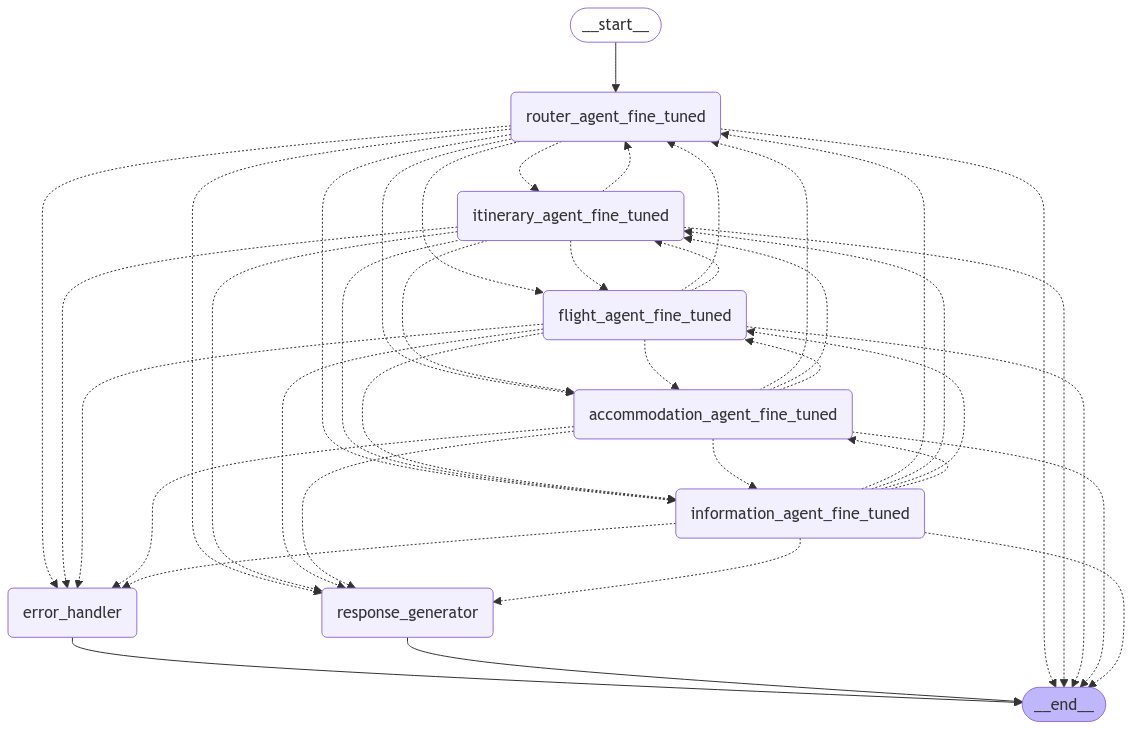

In [21]:
## Step 4: Using the UPDATED Travel Assistant
# Create the travel assistant
travel_assistant_fine_tuned = create_travel_assistant_graph_fine_tuned()

In [22]:
# # Testing the itinerary_agent

result11 = travel_assistant_fine_tuned.invoke({"query": "Plan a 5-day trip to Tokyo in March"})
print(result11)

Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
{'query': 'Plan a 5-day trip to Tokyo in March', 'chat_history': [], 'agent_executor': 'information_agent_fine_tuned', 'agent_response': "Hello! Planning a 5-day trip to Tokyo in March is a fantastic idea, as you'll get to experience the city's stunning blend of modern and traditional elements, complemented by the beautiful early spring scenery. Here's a detailed itinerary to ensure you have a memorable visit:\n\n### **Day 1: Arrival and Exploring Shinjuku**\n- **Morning:** \n  - Arrive in Tokyo and check into your hotel in Shinjuku, a vibrant area with a range of accommodations from luxury to budget-friendly.\n- **Afternoon:** \n  - Visit the Tokyo Metropolitan Government Building. Its free observation decks offer breathtaking views of Tokyo and, on clear days, Mount Fuji.\n- **Evening:** \n  - Immerse yourself in Shinjuku’s energetic nightlife. Enjoy dinner at Omoide Yokocho, known for its quaint alleys fille

In [23]:
test_set = pd.read_csv("comprehensive_travel_agent_test_set.csv")
test_set.head()

,question,agent_target,context,reference_answer
0,Given the hotel’s location in Paris and consid...,Information,Hotel Comprehensive Profile: HOTEL SPLENDID ET...,To determine the most optimal travel season fo...
1,Considering the location and profile of the AP...,Itinerary,Hotel Comprehensive Profile: APPART'CITY CLICH...,Designing an eco-tourism itinerary for APPART'...
2,Given the comprehensive profile and neighborho...,Flight,Hotel Comprehensive Profile: COMFORT HOTEL PAR...,"To ensure a seamless, comfortable, and conveni..."
3,Given the vibrant and multicultural nature of ...,Flight,Local Transportation:\n thumb|260px...,To plan a comprehensive and environmentally-co...
4,Given the detailed profile of the Williams Ope...,Flight,Hotel Comprehensive Profile: WILLIAMS OPERA\n ...,To craft a travel itinerary that optimizes air...


In [24]:
# Generate responses using the travel assistant
generated_answers = []
    
print("Generating responses for evaluation...")
for _, row in test_set.iterrows():
    try:
        # Invoke the travel assistant with the question
        response = travel_assistant_fine_tuned.invoke({
            "query": row['question']
        })
            
        # Convert response to string if it's not already
        generated_answer = str(response)
        generated_answers.append(generated_answer)
    except Exception as e:
        print(f"Error generating response for question: {row['question']}")
        print(f"Error: {e}")
        generated_answers.append("Error generating response")
    
# Add generated answers to the DataFrame
test_set['generated_answer'] = generated_answers

test_set.to_csv("test_set_updated_with_agent_answers-FINE-TUNED.csv")

Generating responses for evaluation...
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_embeddings with dimension 384
Loaded fine-tuned model from travel_assistant_emb

In [25]:
# Prepare dataset for RAGAS evaluation
eval_dataset = Dataset.from_dict({
    'question': test_set['question'],
    'answer': test_set['generated_answer'],                 # Use the generated answers
    'ground_truth': test_set['reference_answer'],           # Reference answers for comparison
    'contexts': test_set['context'].apply(lambda x: [x]),   # Wrap context in a list
})

In [28]:
from ragas import evaluate # updated wall of imports

In [29]:
# Run RAGAS evaluation
print("Running RAGAS evaluation...")

results = evaluate(eval_dataset, metrics=[faithfulness, answer_relevancy, context_precision, context_recall])

Running RAGAS evaluation...


Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

In [30]:
# Print and analyze results
print("\nRAGAS Evaluation Results:")

results


RAGAS Evaluation Results:


{'faithfulness': 0.2095, 'answer_relevancy': 0.8975, 'context_precision': 0.8667, 'context_recall': 0.6512}

In [ ]:
# Agent performance with original embeddings
{'faithfulness': 0.1767, 'answer_relevancy': 0.8325, 'context_precision': 0.8667, 'context_recall': 0.6449}
# Agent performance with fine-tuned embeddings
{'faithfulness': 0.2095, 'answer_relevancy': 0.8975, 'context_precision': 0.8667, 'context_recall': 0.6512}

In [31]:
# Detailed breakdown by agent type
agent_results = {}

for agent in test_set['agent_target'].unique():
    # print(test_set['agent_target'])
    agent_subset = eval_dataset.filter(lambda x, idx: test_set.iloc[idx]['agent_target'] == agent, with_indices=True)
    agent_eval_results = evaluate(agent_subset, metrics=[faithfulness,answer_relevancy,context_precision,context_recall])
    agent_results[agent] = agent_eval_results

Filter:   0%|          | 0/30 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Filter:   0%|          | 0/30 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

Filter:   0%|          | 0/30 [00:00<?, ? examples/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [32]:
# Print and analyze results by agent type
print("\nRAGAS Evaluation Results:")

agent_results


RAGAS Evaluation Results:


{'Information': {'faithfulness': 0.2835, 'answer_relevancy': 0.9324, 'context_precision': 0.8571, 'context_recall': 0.6713},
 'Itinerary': {'faithfulness': 0.0864, 'answer_relevancy': 0.9292, 'context_precision': 0.9231, 'context_recall': 0.6085},
 'Flight': {'faithfulness': 0.4726, 'answer_relevancy': 0.8331, 'context_precision': 0.8000, 'context_recall': 0.5777}}

In [ ]:
# # Agent performance with original embeddings
# {'Information': {'faithfulness': 0.2363, 'answer_relevancy': 0.5312, 'context_precision': 0.8571, 'context_recall': 0.8018},
#  'Itinerary': {'faithfulness': 0.1112, 'answer_relevancy': 0.9268, 'context_precision': 0.9231, 'context_recall': 0.7045},
#  'Flight': {'faithfulness': 0.2866, 'answer_relevancy': 0.9233, 'context_precision': 0.8000, 'context_recall': 0.5864}}
# # Agent performance with fine-tuned embeddings
# {'Information': {'faithfulness': 0.2835, 'answer_relevancy': 0.9324, 'context_precision': 0.8571, 'context_recall': 0.6713},
#  'Itinerary': {'faithfulness': 0.0864, 'answer_relevancy': 0.9292, 'context_precision': 0.9231, 'context_recall': 0.6085},
#  'Flight': {'faithfulness': 0.4726, 'answer_relevancy': 0.8331, 'context_precision': 0.8000, 'context_recall': 0.5777}}

In [33]:
# Save detailed results
results_df = pd.DataFrame({
    'question': test_set['question'],
    'agent_target': test_set['agent_target'],
    'generated_answer': test_set['generated_answer'],
    'reference_answer': test_set['reference_answer'],
    'faithfulness': results['faithfulness'],
    'answer_relevancy': results['answer_relevancy'],
    'context_precision': results['context_precision'],
    'context_recall': results['context_recall']
})

results_df.to_csv('ragas_evaluation_results-FINE-TUNED.csv', index=False)